In [1]:
from string import ascii_lowercase
import itertools
import numpy as np
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from unidecode import unidecode
import sys
np.set_printoptions(threshold=1000)
import re
import matplotlib.pyplot as plt
import itertools

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GL503\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
class MarkovModel():
    
    def __init__(self, n_symbols):
        self.dict_of_symbols = None
        alphabets = ascii_lowercase
        self.n_symbols = n_symbols
        if self.n_symbols == 1:
            self.dict_of_symbols = {letter: index for index, letter in enumerate(alphabets)}
        else:
            combinations = itertools.product(alphabets, repeat = self.n_symbols)
            self.dict_of_symbols = {letter[0]+letter[1]: index for index, letter in enumerate(combinations)}
        self.A = np.zeros((len(self.dict_of_symbols), len(self.dict_of_symbols)), dtype="double")
        self.PI = np.zeros(len(self.dict_of_symbols), dtype="double")
        
    def estimatePI(self, train):
        for sentence in train:
            sentence = re.sub("[^A-Za-z]", "", sentence)
            if self.n_symbols == 1:
                self.PI[self.dict_of_symbols[sentence[0]]] += 1
            else:
                self.PI[self.dict_of_symbols[sentence[0]+sentence[1]]] += 1

        self.PI = self.PI + 1
        self.PI = np.log(self.PI/np.sum(self.PI))
    
    def fit(self, train):
        if self.n_symbols == 1:
            for i in range(len(train)-1):
                a, b = train[i], train[i+1]
                self.A[self.dict_of_symbols[a], self.dict_of_symbols[b]] += 1
        else:
            for i in range(0, len(train)-3, 2):
                a, b = train[i] + train[i+1], train[i+2] + train[i+3]
                self.A[self.dict_of_symbols[a], self.dict_of_symbols[b]] += 1

        self.A = self.A + 1
        self.A = np.log(self.A/np.sum(self.A, axis=1, keepdims=True))
        
    def calculateIndex(self, sentence):
        if self.n_symbols == 1:
            output = self.PI[self.dict_of_symbols[sentence[0]]]
            for i in range(len(sentence)-1):
                a, b = sentence[i], sentence[i+1]
                output += self.A[self.dict_of_symbols[a], self.dict_of_symbols[b]]
            return output
        else:
            output = self.PI[self.dict_of_symbols[sentence[0] + sentence[1]]]
            for i in range(0, len(sentence)-3, 2):
                a, b = sentence[i] + sentence[i+1], sentence[i+2] + sentence[i+3]
                output += self.A[self.dict_of_symbols[a], self.dict_of_symbols[b]]
            return output

In [3]:
with open('Morawiecki.txt', 'r', encoding="utf8") as file:
    morawiecki = file.read().replace("\n", " ")
    
with open('Kaczyński.txt', 'r', encoding="utf8") as file:
    kaczynski = file.read().replace("\n", " ")
    
with open('Szydlo.txt', 'r', encoding="utf8") as file:
    szydlo = file.read().replace("\n", " ")
    
with open('Tusk.txt', 'r', encoding="utf8") as file:
    tusk = file.read().replace("\n", " ")
    
morawiecki = unidecode(morawiecki).lower()
kaczynski = unidecode(kaczynski).lower()
szydlo = unidecode(szydlo).lower()
tusk = unidecode(tusk).lower()

# 1 character

In [4]:
model_morawiecki = MarkovModel(1)
model_kaczynski = MarkovModel(1)
model_szydlo = MarkovModel(1)
model_tusk = MarkovModel(1)

sentences = nltk.tokenize.sent_tokenize(morawiecki)
train, test = train_test_split(sentences, test_size=0.3, random_state=41, shuffle=True)
model_morawiecki.estimatePI(train)

sentences = nltk.tokenize.sent_tokenize(kaczynski)
train, test = train_test_split(sentences, test_size=0.3, random_state=41, shuffle=True)
model_kaczynski.estimatePI(train)

sentences = nltk.tokenize.sent_tokenize(szydlo)
train, test = train_test_split(sentences, test_size=0.3, random_state=41, shuffle=True)
model_szydlo.estimatePI(train)

sentences = nltk.tokenize.sent_tokenize(tusk)
train, test = train_test_split(sentences, test_size=0.3, random_state=41, shuffle=True)
model_tusk.estimatePI(train)

text=re.sub("[^A-Za-z]","",morawiecki)
train, test = train_test_split(text, test_size=0.3, random_state=41, shuffle=False)
model_morawiecki.fit(train)

text=re.sub("[^A-Za-z]","",kaczynski)
train, test = train_test_split(text, test_size=0.3, random_state=41, shuffle=False)
model_kaczynski.fit(train)

text=re.sub("[^A-Za-z]","",szydlo)
train, test = train_test_split(text, test_size=0.3, random_state=41, shuffle=False)
model_szydlo.fit(train)

text=re.sub("[^A-Za-z]","",tusk)
train, test = train_test_split(text, test_size=0.3, random_state=41, shuffle=False)
model_tusk.fit(train)

In [5]:
target_names = [morawiecki, kaczynski, szydlo, tusk]
Y_pred = []
Y_true = []
for index, text in enumerate(target_names):  
    sentences = nltk.tokenize.sent_tokenize(text)
    train, test = train_test_split(sentences, test_size=0.3, random_state=41, shuffle=True)
    for sentence in test:
        sentence = re.sub("[^A-Za-z]", "", sentence)
        Y_true.append(index)
        Y_pred.append(np.argmax([model_morawiecki.calculateIndex(sentence), model_kaczynski.calculateIndex(sentence), model_szydlo.calculateIndex(sentence), model_tusk.calculateIndex(sentence)]))
        
        

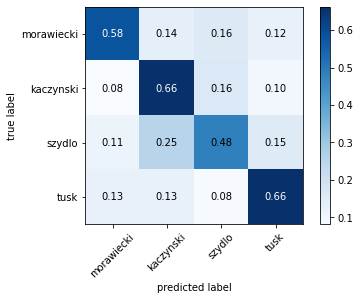

In [6]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(Y_true, Y_pred, normalize="true")
classes = ["morawiecki", "kaczynski", "szydlo", "tusk"]

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

# 2 characters

In [7]:
model_morawiecki = MarkovModel(2)
model_kaczynski = MarkovModel(2)
model_szydlo = MarkovModel(2)
model_tusk = MarkovModel(2)

sentences = nltk.tokenize.sent_tokenize(morawiecki)
train, test = train_test_split(sentences, test_size=0.3, random_state=41, shuffle=True)
model_morawiecki.estimatePI(train)

sentences = nltk.tokenize.sent_tokenize(kaczynski)
train, test = train_test_split(sentences, test_size=0.3, random_state=41, shuffle=True)
model_kaczynski.estimatePI(train)

sentences = nltk.tokenize.sent_tokenize(szydlo)
train, test = train_test_split(sentences, test_size=0.3, random_state=41, shuffle=True)
model_szydlo.estimatePI(train)

sentences = nltk.tokenize.sent_tokenize(tusk)
train, test = train_test_split(sentences, test_size=0.3, random_state=41, shuffle=True)
model_tusk.estimatePI(train)

text=re.sub("[^A-Za-z]","",morawiecki)
train, test = train_test_split(text, test_size=0.3, random_state=41, shuffle=False)
model_morawiecki.fit(train)

text=re.sub("[^A-Za-z]","",kaczynski)
train, test = train_test_split(text, test_size=0.3, random_state=41, shuffle=False)
model_kaczynski.fit(train)

text=re.sub("[^A-Za-z]","",szydlo)
train, test = train_test_split(text, test_size=0.3, random_state=41, shuffle=False)
model_szydlo.fit(train)

text=re.sub("[^A-Za-z]","",tusk)
train, test = train_test_split(text, test_size=0.3, random_state=41, shuffle=False)
model_tusk.fit(train)

In [8]:
target_names = [morawiecki, kaczynski, szydlo, tusk]
Y_pred = []
Y_true = []
for index, text in enumerate(target_names):  
    sentences = nltk.tokenize.sent_tokenize(text)
    train, test = train_test_split(sentences, test_size=0.3, random_state=41, shuffle=True)
    for sentence in test:
        sentence = re.sub("[^A-Za-z]", "", sentence)
        Y_true.append(index)
        Y_pred.append(np.argmax([model_morawiecki.calculateIndex(sentence), model_kaczynski.calculateIndex(sentence), model_szydlo.calculateIndex(sentence), model_tusk.calculateIndex(sentence)]))
        
        

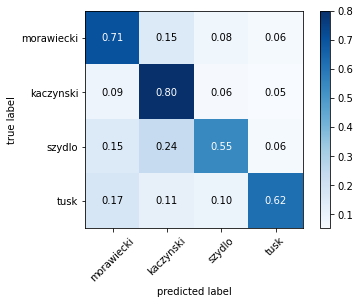

In [9]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(Y_true, Y_pred, normalize="true")
classes = ["morawiecki", "kaczynski", "szydlo", "tusk"]

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

# 1 character - additional tests

In [10]:
model_morawiecki = MarkovModel(1)
model_kaczynski = MarkovModel(1)
model_szydlo = MarkovModel(1)
model_tusk = MarkovModel(1)

sentences = nltk.tokenize.sent_tokenize(morawiecki)
model_morawiecki.estimatePI(sentences)

sentences = nltk.tokenize.sent_tokenize(kaczynski)
model_kaczynski.estimatePI(sentences)

sentences = nltk.tokenize.sent_tokenize(szydlo)
model_szydlo.estimatePI(sentences)

sentences = nltk.tokenize.sent_tokenize(tusk)
model_tusk.estimatePI(sentences)

text=re.sub("[^A-Za-z]","",morawiecki)
model_morawiecki.fit(text)

text=re.sub("[^A-Za-z]","",kaczynski)
model_kaczynski.fit(text)

text=re.sub("[^A-Za-z]","",szydlo)
model_szydlo.fit(text)

text=re.sub("[^A-Za-z]","",tusk)
model_tusk.fit(text)

c:\users\gl503\appdata\local\programs\python\python39\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:94: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


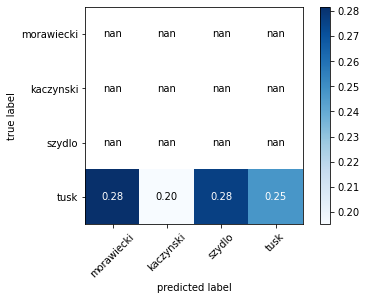

In [11]:
    
with open('Tusk2.txt', 'r', encoding="utf8") as file:
    tusk2 = file.read().replace("\n", " ")
tusk2 = unidecode(tusk2).lower()

Y_pred = []
Y_true = []

sentences = nltk.tokenize.sent_tokenize(tusk2)
for sentence in sentences:
    sentence = re.sub("[^A-Za-z]", "", sentence)
    Y_true.append(3)
    Y_pred.append(np.argmax([model_morawiecki.calculateIndex(sentence), model_kaczynski.calculateIndex(sentence), model_szydlo.calculateIndex(sentence), model_tusk.calculateIndex(sentence)]))
    
cm = confusion_matrix(Y_true, Y_pred, normalize="true")
classes = ["morawiecki", "kaczynski", "szydlo", "tusk"]

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True,
                                   fontcolor_threshold=0.2)

plt.show()

# 2 characters - additional tests

In [12]:
model_morawiecki = MarkovModel(2)
model_kaczynski = MarkovModel(2)
model_szydlo = MarkovModel(2)
model_tusk = MarkovModel(2)

sentences = nltk.tokenize.sent_tokenize(morawiecki)
model_morawiecki.estimatePI(sentences)

sentences = nltk.tokenize.sent_tokenize(kaczynski)
model_kaczynski.estimatePI(sentences)

sentences = nltk.tokenize.sent_tokenize(szydlo)
model_szydlo.estimatePI(sentences)

sentences = nltk.tokenize.sent_tokenize(tusk)
model_tusk.estimatePI(sentences)

text=re.sub("[^A-Za-z]","",morawiecki)
model_morawiecki.fit(text)

text=re.sub("[^A-Za-z]","",kaczynski)
model_kaczynski.fit(text)

text=re.sub("[^A-Za-z]","",szydlo)
model_szydlo.fit(text)

text=re.sub("[^A-Za-z]","",tusk)
model_tusk.fit(text)

c:\users\gl503\appdata\local\programs\python\python39\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:94: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


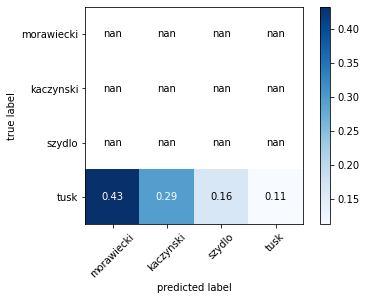

In [13]:
    
with open('Tusk2.txt', 'r', encoding="utf8") as file:
    tusk2 = file.read().replace("\n", " ")
tusk2 = unidecode(tusk2).lower()

Y_pred = []
Y_true = []

sentences = nltk.tokenize.sent_tokenize(tusk2)
for sentence in sentences:
    sentence = re.sub("[^A-Za-z]", "", sentence)
    Y_true.append(3)
    Y_pred.append(np.argmax([model_morawiecki.calculateIndex(sentence), model_kaczynski.calculateIndex(sentence), model_szydlo.calculateIndex(sentence), model_tusk.calculateIndex(sentence)]))
    
cm = confusion_matrix(Y_true, Y_pred, normalize="true")
classes = ["morawiecki", "kaczynski", "szydlo", "tusk"]

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True,
                                   fontcolor_threshold=0.2)

plt.show()